In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from CustomDataLoader import MyDataset
from torch.utils.data import DataLoader
from CRN2 import CRNBasedMagnitudeEstimation
from CNNPhaseEnhance import CNNPhaseEnhancement
from CleanSpeechEstimate import CleanSpeechEstimation
import torch.optim.lr_scheduler as lr_scheduler
from torchsummary import summary

# There we get Channel Dimension only if we get the complex numbers as individual values, otheriwse if we get as complex_value = True then all are as 1 on channel dimension

class SpeechEnhancementModel(nn.Module):
    def __init__(self, crn_params, cnn_params, power_law):
        super(SpeechEnhancementModel, self).__init__()
        self.power_law = power_law
        self.magnitude_estimation = CRNBasedMagnitudeEstimation(**crn_params)
        self.phase_enhancement = CNNPhaseEnhancement(**cnn_params)
        self.clean_speech_estimation = CleanSpeechEstimation(power_law)

    def stft(self,x, fft_size=512, hop_size=256, window='hann'): 
    # Create window function
        if window == 'hann':
            window = torch.hann_window(fft_size)
        else:
            raise ValueError("only hann window is supported.")

        # Compute STFT
        stft_matrix = torch.stft(x, fft_size, hop_size, window=window,return_complex=True) #  = false
        print(stft_matrix)
        return torch.view_as_real(stft_matrix)

    def power_law_compression(self, signal):
        real= signal[..., 0] # real part
        imag= signal[..., 1] # imag part

        compressed_real = torch.pow(torch.abs(real), self.power_law) * torch.sign(real)
     
        compressed_img = torch.pow(torch.abs(imag), self.power_law) * torch.sign(imag)

        compressed_mag = torch.sqrt((compressed_real)**2 + (compressed_img) **2)

        small_value = 1e-7
        compressed_real = torch.where(compressed_real == 0, small_value, compressed_real)
        compressed_img = torch.where(compressed_img == 0, small_value, compressed_img)

        compressed_phase = torch.arctan(compressed_img/compressed_real)
        print("Is it contain NAN at Compressed after bands output",torch.isnan(compressed_phase).any()) 
        # print("compressed phase",compressed_phase)
        
        return compressed_mag,compressed_phase,compressed_real,compressed_img
    

    def istft(self, stft_matrix, fft_size=512, hop_size=256, window='hann'):
    # Convert the input back to complex form if necessary
        # if stft_matrix.size(-1) == 2:
            # stft_matrix = torch.view_as_complex(stft_matrix)

        # Create window function
        if window == 'hann':
            window = torch.hann_window(fft_size)
        else:
            raise ValueError("only hann window is supported.")

        # Compute iSTFT
        x_reconstructed = torch.istft(stft_matrix, n_fft=fft_size, hop_length=hop_size, window=window)
    
        return x_reconstructed
    
    def pad_signal(self,signal, target_length):
        k = target_length
        padding = k - signal.size(-1)
        # print("target is ",k)
        # print("signal size is ",signal.size(-1))
        # print("padding is ",padding)
        if padding > 0:
            signal = torch.nn.functional.pad(signal, (0, padding))
            # print("signal shape is ",signal.shape)
        return signal

    def forward(self, noisy_signal):
        # print(noisy_signal.shape)

        # Apply stft 
        stft_matrix = self.stft(noisy_signal)

        # print("After STFT :",stft_matrix.shape)

        # Apply power law compression
        compressed_mag,compressed_phase,compressed_real,compressed_img = self.power_law_compression(stft_matrix)
        # print("comp phase shape",compressed_phase.shape)

        # print("After power law compression of mag",compressed_mag.shape)

        print("------ CRN Mag estimation block----------")


        magnitude_mask = self.magnitude_estimation(compressed_mag)

        print("Is it contain NAN at Magnitude Mask after bands output",torch.isnan(magnitude_mask).any()) 
        print("Is it contain NAN at Compressed after bands output",torch.isnan(compressed_phase).any()) 

        # print("Magnitude Mask",magnitude_mask)
        # print("Magnitude Mask shape",magnitude_mask.shape)


        print("---- CNN based phase enhancement--------")

        # Stage 2: CNN-based Phase Enhancement

        complex_mask = self.phase_enhancement(magnitude_mask, compressed_phase)
        
        # Clean Speech Estimation
        estimated_clean_speech = self.clean_speech_estimation(complex_mask,compressed_mag,compressed_phase)

        speech = self.istft(estimated_clean_speech)

        # print("Speech in time domain",speech.shape)

        target_length = noisy_signal.size(-1)
        # speech = self.pad_signal(speech,target_length)
        # print("AFter Padding in time domain",speech.shape)
        
        return speech

# Example usage
crn_params = {
    'in_channels': 257,
    'out_channels': 32, 
    'hidden_size': 64, 
    'num_subbands': 2,
}
cnn_params = {
    'in_channels': 2, 
    'out_channels': 32
}


csv_file = './DataLoad/files.csv'
train = './DataLoad/train'
label = './DataLoad/label'  
batches = 1


mdataset = MyDataset(csv=csv_file,train_dir=train,label_dir=label)

train_set ,test_set  = torch.utils.data.random_split(mdataset,[23,23])

train_loader = DataLoader(train_set,batch_size=batches,shuffle=True)
test_loader = DataLoader(test_set,batch_size=batches,shuffle=True)


sample_rate = 16000
duration = 10
channels = 2
num_epochs = 1
learning_rate = 0.00004
power_law = 0.6

# Initialize the model, loss function, and optimizer
model = SpeechEnhancementModel(crn_params, cnn_params,power_law)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=10)


for epoch in range(num_epochs):
    running_loss = 0.0
    for i,data in enumerate(train_loader):
        noisy_waveform, clean_waveform = data

        # Forward pass
        outputs = model(noisy_waveform)
        # model.eval()
        
        # Compute loss
        loss = criterion(outputs, clean_waveform)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

        print('=======================================================================')
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        print('=======================================================================')


print("Training finished!")

# summary(model,(1,1360000))
# k = model(torch.tensor(mdataset.__getitem__(1)[0]))

tensor([[[-3.0759e-01+0.0000e+00j,  1.9076e-01+0.0000e+00j,
           9.6065e-02+0.0000e+00j,  ...,
          -3.6401e-01+0.0000e+00j,  5.5981e-02+0.0000e+00j,
          -3.1968e-01+0.0000e+00j],
         [ 3.1157e-01-6.1197e-09j, -2.9376e-01-2.1464e-01j,
          -1.5277e-01+2.7788e-01j,  ...,
           2.9965e-01+5.1738e-02j, -2.2105e-01-1.1188e-01j,
           1.6147e-02-3.5279e-03j],
         [-1.2677e-01-1.7088e-08j,  3.1481e-01+2.4907e-01j,
           3.6447e-02-2.7067e-01j,  ...,
          -2.1532e-01-2.6235e-02j,  3.2801e-01-4.9960e-02j,
           3.8348e-01+1.0593e-02j],
         ...,
         [ 1.0942e-03-2.1795e-09j, -3.8409e-08-4.0074e-09j,
           1.3607e-09+1.4513e-08j,  ...,
          -3.5093e-07-2.1532e-07j, -1.7910e-06-1.0436e-07j,
           3.2374e-03-7.9565e-05j],
         [-1.0939e-03-6.1976e-09j, -3.5871e-08-1.5980e-09j,
          -3.3487e-10-5.2293e-09j,  ...,
          -9.3112e-08+5.8996e-08j, -1.8520e-06-7.5787e-08j,
          -3.2363e-03+3.9683e-05j],
 

In [ ]:
for param in model.parameters():
      print("param.data",torch.isfinite(param.data).all())
      print("param.grad.data",torch.isfinite(param.grad.data).all(),"\n")

In [2]:
inp = torch.rand([1, 257, 5168,3])
inp.size(-2)

5168

In [ ]:
"""
Normal Convolution and depthwise-separable convolutions 
should output a vector with the same dimensions
input shape = 3, 28, 38 (RGB image of 28x 28)
output shape = 10, 28, 28 (10 output channels with same width and height)
"""
import torch
import torch.nn as nn

inp = torch.rand([1, 257, 5168,3])

### Conv2d (normal)
conv_layer= nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1)
conv_layer_n_params = sum(p.numel() for p in conv_layer.parameters() if p.requires_grad)
conv_out = conv_layer(inp)
print(f"Conv layer param numbers: {conv_layer_n_params}")
print(conv_out.shape)

### Depthwise convolution
# by adding 'groups' param, you perform depthwise conv
depthwise_layer= nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1, groups=1)
depthwise_layer_n_params = sum(p.numel() for p in depthwise_layer.parameters() if p.requires_grad)
depthwise_out = depthwise_layer(inp)
print(f"DepthwiseConv layer param numbers: {depthwise_layer_n_params}")
print(depthwise_out.shape)

### Pointwise Convolution (using depthwise output) <-- This is called DEPTHWISE-SEPARABLE CONVOLUTION
pointwise_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=1)
pointwise_layer_n_params = sum(p.numel() for p in pointwise_layer.parameters() if p.requires_grad)
pointwise_out = pointwise_layer(depthwise_out)
print(f"PointwiseConv layer param numbers: {pointwise_layer_n_params}")
print(pointwise_out.shape)

print(f"Conv params: {conv_layer_n_params} / Depthwise-separable params: {depthwise_layer_n_params + pointwise_layer_n_params}")

In [ ]:
import torch
import torch.nn as nn

# Generating input tensor with shape [1, 1, 257, 5168] instead of [1, 257, 5168, 2]
# inp = torch.rand([1, 1, 257, 5168])



# 1D Convolution for depthwise and pointwise
# Changing the input to [1, 257, 5168] as we need 3D input for 1D convolution
inp = torch.rand([257, 1, 5168])


conv_layer= nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, padding=1)
conv_layer_n_params = sum(p.numel() for p in conv_layer.parameters() if p.requires_grad)
conv_out = conv_layer(inp)
print(f"Conv layer param numbers: {conv_layer_n_params}")
print(conv_out.shape)


### Depthwise 1D convolution
depthwise_1d_layer = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding=1, groups=1)
depthwise_1d_layer_n_params = sum(p.numel() for p in depthwise_1d_layer.parameters() if p.requires_grad)
depthwise_1d_out = depthwise_1d_layer(inp)
print(f"Depthwise 1D Conv layer param numbers: {depthwise_1d_layer_n_params}")
print(depthwise_1d_out.shape)

### Pointwise 1D Convolution (using depthwise output) <-- This is called DEPTHWISE-SEPARABLE CONVOLUTION in 1D
pointwise_1d_layer = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=1)
pointwise_1d_layer_n_params = sum(p.numel() for p in pointwise_1d_layer.parameters() if p.requires_grad)
pointwise_1d_out = pointwise_1d_layer(depthwise_1d_out)
print(f"Pointwise 1D Conv layer param numbers: {pointwise_1d_layer_n_params}")
print(pointwise_1d_out.shape)

print(f"Conv 1D params: {depthwise_1d_layer_n_params + pointwise_1d_layer_n_params}")


In [ ]:
m = nn.Conv1d(1, 33, 3, stride=2)
input = torch.rand([257, 1, 5168])
output = m(input)
output.shape

In [4]:
x = torch.arange(50,dtype=torch.float).view(10,5)
x.shape

torch.Size([10, 5])

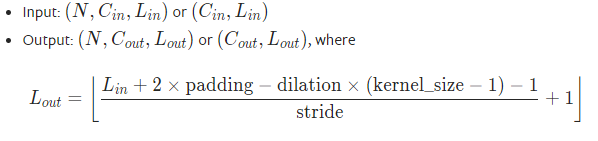

In [3]:
import torch
import torch.nn as nn

# Example audio signal tensor of shape (batch_size, frequency_bins, time_frames)
audio_signal = torch.randn(1, 257, 5168)  # Shape: (1, 257, 5168)

# Transpose to swap frequency_bins and time_frames
# Shape after transpose: (batch_size, time_frames, frequency_bins)
audio_signal_transposed = audio_signal.transpose(1, 2)

# Define a MaxPool1d layer
kernel_size = 4  # Pooling size along the frequency dimension
stride = 2       # Stride along the frequency dimension

maxpool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride)

# Apply MaxPool1d along the frequency dimension (which is now the last dimension)
pooled_signal_transposed = maxpool(audio_signal_transposed)

# Transpose back to the original shape (batch_size, frequency_bins, time_frames)
pooled_signal = pooled_signal_transposed.transpose(1, 2)

# Print the shapes of the original and pooled signals
print("Original Signal Shape:", audio_signal.shape)  # Shape: (1, 257, 5168)
print("Pooled Signal Shape:", pooled_signal.shape)   # Shape: (1, new_frequency_bins, 5168)

# Example output of the pooled signal
print("Pooled Signal:", pooled_signal.shape)


Original Signal Shape: torch.Size([1, 257, 5168])
Pooled Signal Shape: torch.Size([1, 127, 5168])
Pooled Signal: torch.Size([1, 127, 5168])


In [5]:
import torch.nn as nn
import torch

class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv1D, self).__init__()
    
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(1,3), stride=1, padding=1, downsample=False):
        super(ConvBlock, self).__init__()
        self.conv = DepthwiseSeparableConv1D(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.downsample = downsample
        # if self.downsample:
            # self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        # if self.downsample:
            # x = self.pool(x)
        return x



class CRNBasedMagnitudeEstimation(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size, kernel_size=(1,3), stride=1, padding=1):
        super(CRNBasedMagnitudeEstimation, self).__init__()
        self.inchannels = in_channels

        filters = [32,64,96,128]


    def perform_conv(self,x):
        channels = [32, 64, 96, 128]

        limit = [0,16, 32, 64, 128, 256]
        subbands = []
        i = 0
        while i < len(limit) - 1:
                start = limit[i]
                end = limit[i + 1]
                subband = x[:, start:end, :]
                print(subband.shape)
                i = i +1
                subbands.append(subband)


    def forward(self, x):
        # print(x.shape)

        # Channelwise feature reorientation 
        # subbands_result = []

        # limit = [1,16, 32, 64, 128, 256]
        
        # for i in range(len(limit) - 1):

        #     start = limit[i]
        #     end = limit[i + 1]
        #     print(start,end)
        #     print(x.shape)
        #     print(x[:, start:end, :].shape)
        #     result = self.perform_conv(x[:, start:end, :])
        #     print("result",result.shape)
        #     # subbands_result.append(result)
        #     print("------------------")
        
        x = torch.cat(subbands_result, dim=1)
        print("After concatenated subbands",x.shape)
        


# def perform_conv(x,in_channels):
#     channels = [32,64,96,128]

#     for out_channels in channels:
#         conv_block = ConvBlock(in_channels, out_channels)
#         x = conv_block(x)
#         print("Each Band",x.shape)
#         in_channels = out_channels 
#     return x


# subbands_result = []

# limit = [16, 32, 64, 128, 257]

# for i in range(0,len(limit)):
#     start = 0
#     subband = y[:, start:limit[i], :]
#     start = limit[i] +1
#     result = perform_conv(subband,in_channels)
#     print("------------------")
#     subbands_result.append(subband)
    


# x = torch.cat(subbands_result, dim=1)
# print(x.shape)

y = torch.randn([1, 257, 5168])

in_channels = 257

model = CRNBasedMagnitudeEstimation(in_channels,10,32)
result = model(y)
result.shape

NameError: name 'subbands_result' is not defined

In [ ]:
import torch.nn as nn
import torch

class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv1D, self).__init__()
    
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=(3),stride=1,padding=1,groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(1,3), stride=1, padding=1,downsample=False):
        super(ConvBlock, self).__init__()
        self.conv = DepthwiseSeparableConv1D(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.downsample = downsample
        if self.downsample:
            self.pool = nn.MaxPool1d(kernel_size=2,stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.downsample:
            self.pool(x)
        return x



i = torch.randn([1, 257, 5168])
in_channels = 257

li = []

result0 = ConvBlock(in_channels,15)
r = result0.forward(i)
li.append(r)
print(r.shape)


result0 = ConvBlock(15,32 )
r = result0.forward(r)
li.append(r)
print(r.shape)

result1 = ConvBlock(32,64)
r = result1.forward(r)
li.append(r)
print(r.shape)

result2 =  ConvBlock(64, 96)
r = result2.forward(r)
li.append(r)
print(r.shape)

result3 =  ConvBlock(96, 128)
r = result3.forward(r)
li.append(r)
print(r.shape)


x = torch.cat(li, dim=1)
# print(x)
print(x.shape)

filters = [32,64,96,128]


torch.Size([1, 15, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 96, 5168])
torch.Size([1, 128, 5168])
torch.Size([1, 335, 5168])


In [6]:
import torch.nn as nn
import torch
from torchsummary import summary

class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv1D, self).__init__()
    
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=(3),stride=1,padding=1,groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(1,3), stride=1, padding=1,downsample=False):
        super(ConvBlock, self).__init__()
        self.conv = DepthwiseSeparableConv1D(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.downsample = downsample
        if self.downsample:
            self.pool = nn.MaxPool1d(kernel_size=2,stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.downsample:
            self.pool(x)
        return x


i = torch.randn([1, 257, 5168])
in_channels = 257

result0 = ConvBlock(in_channels,15)
r = result0.forward(i)

summary(result0,i)

Layer (type:depth-idx)                   Output Shape              Param #
├─DepthwiseSeparableConv1D: 1-1          [-1, 15, 5168]            --
|    └─Conv1d: 2-1                       [-1, 257, 5168]           1,028
|    └─Conv1d: 2-2                       [-1, 15, 5168]            3,870
|    └─ReLU: 2-3                         [-1, 15, 5168]            --
├─ReLU: 1-2                              [-1, 15, 5168]            --
Total params: 4,898
Trainable params: 4,898
Non-trainable params: 0
Total mult-adds (M): 23.91
Input size (MB): 5.07
Forward/backward pass size (MB): 10.72
Params size (MB): 0.02
Estimated Total Size (MB): 15.81


Layer (type:depth-idx)                   Output Shape              Param #
├─DepthwiseSeparableConv1D: 1-1          [-1, 15, 5168]            --
|    └─Conv1d: 2-1                       [-1, 257, 5168]           1,028
|    └─Conv1d: 2-2                       [-1, 15, 5168]            3,870
|    └─ReLU: 2-3                         [-1, 15, 5168]            --
├─ReLU: 1-2                              [-1, 15, 5168]            --
Total params: 4,898
Trainable params: 4,898
Non-trainable params: 0
Total mult-adds (M): 23.91
Input size (MB): 5.07
Forward/backward pass size (MB): 10.72
Params size (MB): 0.02
Estimated Total Size (MB): 15.81

In [ ]:
import  torch.nn as nn
import torch

class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv1D, self).__init__()
    
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=(3),stride=1,padding=1,groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(1,3), stride=1, padding=1,downsample=False):
        super(ConvBlock, self).__init__()
        self.conv = DepthwiseSeparableConv1D(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.downsample = downsample
        if self.downsample:
            self.pool = nn.MaxPool1d(kernel_size=2,stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.downsample:
            self.pool(x)
        return x


import torch
limit = [0,16, 32, 64, 128, 257]
x = torch.rand(1, 257, 5168)
channels = [64,64,64,32,32]

subbands = []

conv = 5
i = 0
while i < len(limit) - 1:
        start = limit[i] +1
        end = limit[i + 1]
        # print(start,end)
        subband = x[:, start:end, :]
        i = i +1
        subbands.append(subband)

    
        

bands_output = []
for band in subbands:
    for j in range(0,conv):
        # print(band.shape[1],channels[j])
        band = ConvBlock(band.shape[1],channels[j])(band)
        print(band.shape)
    print('==========')
    bands_output.append(band)


x = torch.cat(bands_output, dim=1)
x.shape

torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 64, 5168])
torch.Size([1, 32, 5168])
torch.Size([1, 32, 5168])


torch.Size([1, 160, 5168])

In [ ]:
import torch
import torch.nn as nn

class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv1D, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=False):
        super(ConvBlock, self).__init__()
        self.conv = DepthwiseSeparableConv1D(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.downsample = downsample
        if self.downsample:
            self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.downsample:
            x = self.pool(x)
        return x

# Define the frequency bin limits with overlaps and padding
limits = [(0, 16), (16, 32), (32, 64), (64, 128), (128, 257)]
overlap = 4
padding = 2

x = torch.rand(1, 257, 5168)
subbands = []

for start, end in limits:
    padded_start = max(0, start - padding)
    padded_end = min(x.shape[1], end + padding)
    subband = x[:, padded_start:padded_end, :]
    subbands.append(subband)

# Define the channels for each ConvBlock
channels = [32, 64, 96, 128]
conv_blocks = len(channels)

bands_output = []
for band in subbands:
    for j in range(conv_blocks):
        band = ConvBlock(band.shape[1], channels[j])(band)
    bands_output.append(band)

# Concatenate the processed subbands
x = torch.cat(bands_output, dim=1)
print(x.shape)


torch.Size([1, 640, 5168])


In [ ]:



signal = torch.randn([1, 257, 5168])
k = conv = DepthwiseSeparableConv1D(in_channels=1, out_channels=1, kernel_size=(1,3), stride=1, padding=1)
re = k(signal)
re

